In [12]:
import pickle
from copy import deepcopy
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor

from scripts.config import *
from scripts.data_processing.common_methods import get_processed_data, get_available_dataset_ids, get_features_from_pulse_data_v2, get_features_from_pulse_data_v4
from scripts.modeling.common_methods import ModelOptimizer, create_MLP_model

# Generate Feature Importance Metrics

This is done by optimizing a set of linear models and a random forest regression to a select set of features. The linear model coefficients and random forest feature importance values indicate which features have the most importance on the prediction

In [ ]:
random_state = 13
params = {
	1:{'model_to_use':'ridge', 'n_trials':100},
 	# 2:{'model_to_use':'lasso', 'n_trials':300},
  	# 3:{'model_to_use':'elasticnet', 'n_trials':600},
  	# 4:{'model_to_use':'randomforest', 'n_trials':1000},
  	# 5:{'model_to_use':'mlp', 'n_trials':1000},
}
for k in params.keys():
	model_to_use = params[k]['model_to_use']
	n_trials = params[k]['n_trials']
	
	# run optimization on all datasets, all pulse types, and all socs for the given model type
	for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
		#region: load all pulse data
		try:
			file_data = sorted(list(dir_processed_data.joinpath(dataset_id).glob('data_slowpulse*.pkl')))[-1]
		except IndexError:
			from scripts.data_processing.postprocessing import perform_postprocessing
			file_data = perform_postprocessing(dataset_id, data_type='slowpulse', verbose=0)
		data = pickle.load(open(file_data, 'rb'))
		#endregion

		for p_type in ['chg', 'dchg']:
			# optimize model on each SOC individually
			all_soc_tests = np.hstack([dic_available_dataset_info[dataset_id]['pulse_socs_tested'], None])
			for soc in all_soc_tests:
				# get features and targets
				features, targets, cell_ids = get_features_from_pulse_data_v2(data, pulse_type=p_type, pulse_soc=soc)
				kf = KFold(n_splits=3, shuffle=True, random_state=random_state)
				splits = list(kf.split(features, targets, cell_ids))

				#region: optimize model
				model_optimizer = ModelOptimizer(
					features=features,
					targets=targets,
					splits=splits,
					model_to_use=model_to_use,
					n_trials=n_trials,
					data_scaler=StandardScaler,
					random_state=random_state
				)
				# dir_save = dir_results.joinpath("model_optimization", 'features_v2_new', dataset_id, f"{p_type}_{soc if soc is not None else 'all'}")
				# dir_save.mkdir(exist_ok=True, parents=True)
				dir_save = None
				model_optimizer.optimize_model(dir_save=dir_save)
				#endregion


Another way to view feature importance is to evaluate the source model's performance using each feature individually

2025-02-20 14:57:56.193521: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


111/111 [==============================] - 0s 482us/step


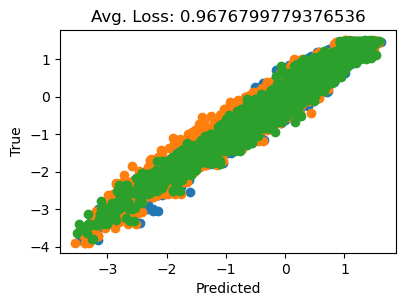

112/112 [==============================] - 0s 345us/step


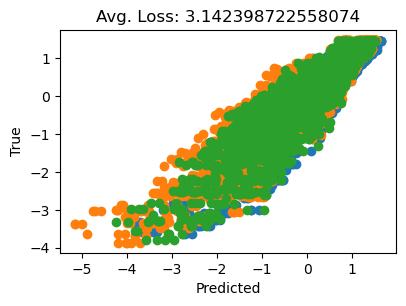

112/112 [==============================] - 0s 340us/step


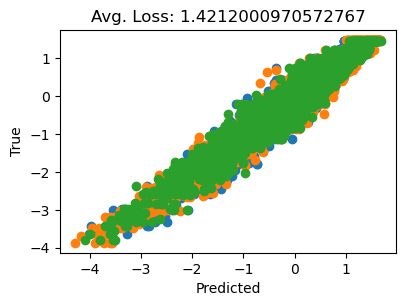

112/112 [==============================] - 0s 343us/step


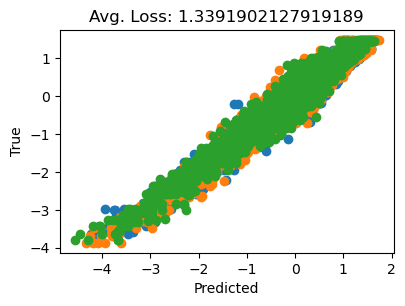

In [7]:
dataset_id = 'UConn-ILCC-NMC'
model_to_use = 'mlp'
pulse_type = 'chg'
soc_key = 'all'

def _get_timestamp(path:Path, model_to_use:str):
	start_idx = str(path.name).rindex(f'modelOptimization_{model_to_use}_') + len(f'modelOptimization_{model_to_use}_')
	end_idx = str(path.name).rindex('_study.pkl')
	return int(str(path.name)[start_idx:end_idx])

def evaluate_model(model, features, targets, splits, data_scaler=StandardScaler, error_fnc=root_mean_squared_error, plot:bool=False):
	"""Evaluates the optimal models performance over the specified splits. 

	Args:
		plot (bool, optional): If True, predictions v true are plotted for each split. Defaults to False.
	"""

	all_errors = []
	fig, ax = (None, None)
	if plot: fig, ax = plt.subplots(figsize=(4,3))
	for i, (train_idxs, test_idxs) in enumerate(splits):
		X = deepcopy(features)
		y = deepcopy(targets)
		#region: scale data if specified
		if data_scaler is not None:
			scaler_X = data_scaler().fit(X[train_idxs])
			scaler_y = data_scaler().fit(y[train_idxs])
			X = scaler_X.transform(X)
			y = scaler_y.transform(y)
		#endregion

		# fit model to scaled input and output data
		model.fit(X[train_idxs], y[train_idxs])
		# get predictions
		yhat = model.predict(X[test_idxs])
		# append error for this split
		all_errors.append(error_fnc(y[test_idxs], yhat))
		if plot:
			ax.scatter(yhat, y[test_idxs], label=f"CV {i}")

	all_errors = np.asarray(all_errors)

	if plot:
		ax.set_xlabel("Predicted")
		ax.set_ylabel("True")
		ax.set_title(f"Avg. Loss: {np.average(all_errors)}")
		fig.tight_layout(pad=0.5)
		plt.show()
	else:
		message = '\n' + '*'*100
		message += '\n' + f' {len(splits)}-Fold Loss: {np.average(all_errors)}' 
		message += '\n' + '*'*100 + '\n'
		print(message)

	return all_errors


# Want to compare relative voltage (100 features), to voltage endpoints (6 features), 
#   to voltage mean + standard deviation, to PCA (2 features)
results = {
	'rel_voltage':None,
	'mean_std':None,
	'voltage_endpoints':None,
	'PCA':None
}

#region: Part 1: relative voltage
#region: load study & data
dir_temp = dir_results.joinpath('model_optimization', 'using_relative_voltage', dataset_id, f'{pulse_type}_{soc_key}')
file_study = sorted(list(dir_temp.glob(f'modelOptimization_{model_to_use}_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use=model_to_use)))[-1]
assert file_study.is_file()
file_data = dir_temp.joinpath(f'modelOptimization_{model_to_use}_{_get_timestamp(file_study, model_to_use=model_to_use)}_data.pkl')
assert file_data.is_file()
#endregion

study = pickle.load(open(file_study, 'rb'))
data = pickle.load(open(file_data, 'rb'))
features = data['features']
targets = data['targets']
splits = data['splits']
model = create_MLP_model(**study.best_trial.params, input_shape=len(features[0]), output_shape=len(targets[0]))
data_scaler = StandardScaler

results['rel_voltage'] = evaluate_model(
	model=model, features=features, targets=targets, splits=splits, 
	data_scaler=data_scaler, error_fnc=mean_absolute_percentage_error, plot=True)
#endregion

#region: Part 2: mean + std of voltage
#region: load study & data
dir_temp = dir_results.joinpath('model_optimization', 'features_v4', dataset_id, f'{pulse_type}_{soc_key}')
file_study = sorted(list(dir_temp.glob(f'modelOptimization_{model_to_use}_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use=model_to_use)))[-1]
assert file_study.is_file()
file_data = dir_temp.joinpath(f'modelOptimization_{model_to_use}_{_get_timestamp(file_study, model_to_use=model_to_use)}_data.pkl')
assert file_data.is_file()
#endregion

study = pickle.load(open(file_study, 'rb'))
data = pickle.load(open(file_data, 'rb'))
features = np.vstack([data['features'][:,0], data['features'][:,2]]).T
targets = data['targets']
splits = data['splits']
model = create_MLP_model(**study.best_trial.params, input_shape=len(features[0]), output_shape=len(targets[0]))
data_scaler = StandardScaler

results['mean_std'] = evaluate_model(
	model=model, features=features, targets=targets, splits=splits, 
	data_scaler=data_scaler, error_fnc=mean_absolute_percentage_error, plot=True)
#endregion

#region: Part 3: voltage endpoints
#region: load study & data
dir_temp = dir_results.joinpath('model_optimization', 'features_v4', dataset_id, f'{pulse_type}_{soc_key}')
file_study = sorted(list(dir_temp.glob(f'modelOptimization_{model_to_use}_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use=model_to_use)))[-1]
assert file_study.is_file()
file_data = dir_temp.joinpath(f'modelOptimization_{model_to_use}_{_get_timestamp(file_study, model_to_use=model_to_use)}_data.pkl')
assert file_data.is_file()
#endregion

study = pickle.load(open(file_study, 'rb'))
data = pickle.load(open(file_data, 'rb'))
features = data['features'][:,4:10]
targets = data['targets']
splits = data['splits']
model = create_MLP_model(**study.best_trial.params, input_shape=len(features[0]), output_shape=len(targets[0]))
data_scaler = StandardScaler

results['voltage_endpoints'] = evaluate_model(
	model=model, features=features, targets=targets, splits=splits, 
	data_scaler=data_scaler, error_fnc=mean_absolute_percentage_error, plot=True)
#endregion

# region: Part 4: PCA
#region: load study & data
dir_temp = dir_results.joinpath('model_optimization', 'features_v4', dataset_id, f'{pulse_type}_{soc_key}')
file_study = sorted(list(dir_temp.glob(f'modelOptimization_{model_to_use}_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use=model_to_use)))[-1]
assert file_study.is_file()
file_data = dir_temp.joinpath(f'modelOptimization_{model_to_use}_{_get_timestamp(file_study, model_to_use=model_to_use)}_data.pkl')
assert file_data.is_file()
#endregion

study = pickle.load(open(file_study, 'rb'))
data = pickle.load(open(file_data, 'rb'))
features = data['features'][:,10:15]
targets = data['targets']
splits = data['splits']
model = create_MLP_model(**study.best_trial.params, input_shape=len(features[0]), output_shape=len(targets[0]))
data_scaler = StandardScaler

results['PCA'] = evaluate_model(
	model=model, features=features, targets=targets, splits=splits, 
	data_scaler=data_scaler, error_fnc=mean_absolute_percentage_error, plot=True)
#endregion


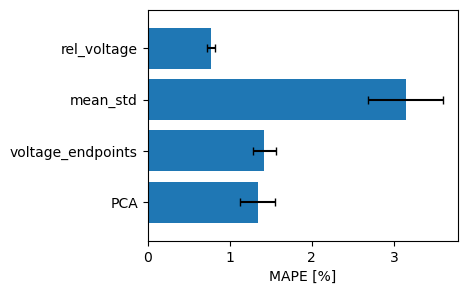

In [8]:
fig, ax = plt.subplots(figsize=(4,3))
for i, k in enumerate(list(results.keys())):
    multiplier = 1
    if i == 0: multiplier = 0.8
    ax.barh(i, np.mean(results[k])*multiplier, color='C0')
    ax.errorbar(np.mean(results[k])*multiplier, i, yerr=None, xerr=np.std(results[k])*multiplier/3, color='k', capsize=3)

ax.set_yticks(np.arange(0,len(results.keys())), list(results.keys()), rotation=0)
ax.set_ylim([3.75,-0.75])
ax.set_xlabel("MAPE [%]")
plt.show()

## Plot Feature Importance

/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.482e+00, tolerance: 1.903e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e+00, tolerance: 1.903e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/envTL/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

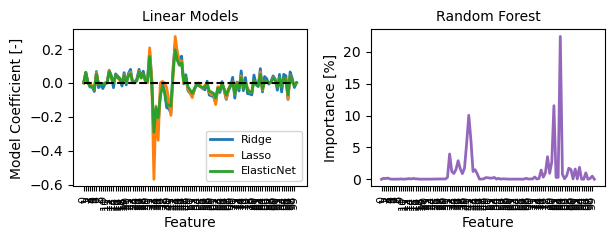

In [13]:
def plot_feature_importance(dataset_id:str, pulse_type:str, soc_key:str='all', dir_save:Path=None):
	"""Plots the feature importance using linear model coefficients and randomforest importance values

	Args:
		dataset_id (str): The name of the dataset to use. See 'get_available_dataset_ids()' for a list of available datasets
		pulse_type (str): {'chg', 'dchg'}. The pulse type to use as a feature.
		soc_key (str, optional): Must be a single soc (ex. '20') or 'all'. Defaults to 'all'.
		dir_save (Path, optional): The plot will be saved to this directory if specified. Defaults to None.
	"""
	assert dataset_id in get_available_dataset_ids()
	assert pulse_type in ['chg', 'dchg']
	assert soc_key in np.hstack([['all'], dic_available_dataset_info[dataset_id]['pulse_socs_tested']]).astype(str)
	random_state = 13
	features_to_use = 1		#TODO: SET THIS TO USE THE CORRESPONDING RESULTS MAPPED BELOW
	feature_name_map = {
		0:['using_relative_voltage', 'features_v2', np.arange(0,100,1)],
		1:['features_v2_new', 'features_v2_new', np.arange(0,100,1)],
		2:['features_v4', 'features_v4', 
	 	   [r'$\mu_{V}$', r'$med(V)$', r'$\sigma_{V}$', r'$A_{V}$', 
	        r'$V_{0}$', r'$V_{29}$', r'$V_{30}$', r'$V_{39}$', r'$V_{40}$', r'$V_{99}$', 
			r'$PCA_{1}$', r'$PCA_{2}$', r'$PCA_{3}$', r'$PCA_{4}$', r'$PCA_{5}$']],
	}

	plot_params = {
		'ridge': {'legend_key':'Ridge', 'color':'C0',},
		'lasso': {'legend_key':'Lasso', 'color':'C1',},
		'elasticnet': {'legend_key':'ElasticNet', 'color':'C2',},
		'randomforest': {'legend_key':'RandomForest', 'color':'C4',},
	}

	fig, gs, axes = None, None, None
	if features_to_use == 0:
		fig = plt.figure(figsize=(6.25,3.75))
		gs = GridSpec(nrows=2, ncols=2, height_ratios=[3,2], width_ratios=[1,1])
		axes = [
			fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
			fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])
		]
		axes[0].set_xticklabels([])
		axes[1].set_xticklabels([])
	elif features_to_use == 1:
		fig = plt.figure(figsize=(6.25,2.5))
		gs = GridSpec(nrows=1, ncols=2, width_ratios=[1,1])
		axes = [
			fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])
		]

	def _get_timestamp(path:Path, model_to_use:str):
		start_idx = str(path.name).rindex(f'modelOptimization_{model_to_use}_') + len(f'modelOptimization_{model_to_use}_')
		end_idx = str(path.name).rindex('_study.pkl')
		return int(str(path.name)[start_idx:end_idx])

	for model_to_use in ['ridge', 'lasso', 'elasticnet', 'randomforest']:
		#region: load study & data
		dir_temp = dir_results.joinpath('model_optimization', feature_name_map[features_to_use][0], dataset_id, f'{pulse_type}_{soc_key}')
		file_study = sorted(list(dir_temp.glob(f'modelOptimization_{model_to_use}_*_study.pkl')), key=(lambda x: _get_timestamp(x, model_to_use=model_to_use)))[-1]
		assert file_study.is_file()
		file_data = dir_temp.joinpath(f'modelOptimization_{model_to_use}_{_get_timestamp(file_study, model_to_use=model_to_use)}_data.pkl')
		assert file_data.is_file()
		#endregion
		study = pickle.load(open(file_study, 'rb'))
		data = pickle.load(open(file_data, 'rb'))
		features = data['features']
		targets = data['targets']
		splits = data['splits']

		#region: create model with optimal parameters from study
		model = None
		if model_to_use == 'ridge':
			model = Ridge(**study.best_trial.params, random_state=random_state)
		elif model_to_use == 'lasso':
			model = Lasso(**study.best_trial.params, random_state=random_state)
		elif model_to_use == 'elasticnet':
			model = ElasticNet(**study.best_trial.params, random_state=random_state)
		elif model_to_use == 'randomforest':
			model = RandomForestRegressor(**study.best_trial.params, random_state=random_state)
		elif model_to_use == 'mlp':
			model = create_MLP_model(**study.best_trial.params)
		data_scaler = StandardScaler
		#endregion

		if model_to_use in ['ridge', 'lasso', 'elasticnet']:
			#region: average coeffs over all cv splits
			coeffs = []
			for train_idxs, test_idxs in splits:
				#region: fit model to training data
				X = deepcopy(features)
				y = deepcopy(targets)
				#region: scale data if specified
				if data_scaler is not None:
					scaler_X = data_scaler().fit(X[train_idxs])
					scaler_y = data_scaler().fit(y[train_idxs])
					X = scaler_X.transform(X)
					y = scaler_y.transform(y)
				#endregion

				# fit model to scaled input and output data
				model.fit(X[train_idxs], y[train_idxs])
				#endregion
				# add the model coeffs for this cv splits
				coeffs.append( model.coef_.ravel() )
			#endregion
			coeffs_avg = np.mean(np.asarray(coeffs), axis=0)
			coeffs_std = np.std(np.asarray(coeffs), axis=0)

			axes[0].plot(
				coeffs_avg, '-', linewidth=2,
				color=plot_params[model_to_use]['color'],
				label=plot_params[model_to_use]['legend_key'])
			
			# region: overlay feature importance on pulse profile
			if features_to_use == 0:
				if model_to_use == 'ridge':
					pulse_v = features[train_idxs][0,:]*1000
					axes[2].plot(pulse_v, 'k', linewidth=2)
					ybounds = [np.min(pulse_v), np.max(pulse_v)]
					ybounds[0] -= (ybounds[1]-ybounds[0])*0.05
					ybounds[1] += (ybounds[1]-ybounds[0])*0.05

					norm_coeff = abs(coeffs_avg)
					norm_coeff = (norm_coeff - np.min(norm_coeff)) / (np.max(norm_coeff) - np.min(norm_coeff))
					for i in np.arange(0,len(norm_coeff),1):
						axes[2].fill_betweenx(
							ybounds, i-0.5, i+0.5, 
							color=plot_params[model_to_use]['color'], edgecolor='none', alpha=norm_coeff[i])
					axes[2].set_xlim([-5,104])
					axes[2].set_ylim(ybounds)
			#endregion

		elif model_to_use == 'randomforest':
			#region: average importances over all cv splits
			importances = []
			for train_idxs, test_idxs in splits:
				#region: fit model to training data
				X = deepcopy(features)
				y = deepcopy(targets)
				#region: scale data if specified
				if data_scaler is not None:
					scaler_X = data_scaler().fit(X[train_idxs])
					scaler_y = data_scaler().fit(y[train_idxs])
					X = scaler_X.transform(X)
					y = scaler_y.transform(y)
				#endregion

				# fit model to scaled input and output data
				model.fit(X[train_idxs], y[train_idxs])
				#endregion
				# add the model importances for this cv splits
				importances.append( model.feature_importances_.ravel() )
			#endregion
			importances_avg = np.mean(np.asarray(importances), axis=0)
			importances_std = np.std(np.asarray(importances), axis=0)

			axes[1].plot(
				importances_avg*100, '-', linewidth=2,
				color=plot_params[model_to_use]['color'],
				label=plot_params[model_to_use]['legend_key'])
			
			# region: overlay feature importance on pulse profile
			if features_to_use == 0:
				pulse_v = features[train_idxs][0,:]*1000
				axes[3].plot(pulse_v, 'k', linewidth=2)
				ybounds = [np.min(pulse_v), np.max(pulse_v)]
				ybounds[0] -= (ybounds[1]-ybounds[0])*0.05
				ybounds[1] += (ybounds[1]-ybounds[0])*0.05

				norm_coeff = abs(importances_avg)
				norm_coeff = (norm_coeff - np.min(norm_coeff)) / (np.max(norm_coeff) - np.min(norm_coeff))
				for i in np.arange(0,len(norm_coeff),1):
					axes[3].fill_betweenx(
						ybounds, i-0.5, i+0.5, 
						color=plot_params[model_to_use]['color'], edgecolor='none', alpha=norm_coeff[i])
				axes[3].set_xlim([-5,104])
				axes[3].set_ylim(ybounds)
			#endregion


	#region: set labels
	feature_ticks = np.arange(len(feature_name_map[features_to_use][2]))
	feature_bounds = (np.min(feature_ticks), np.max(feature_ticks))
	axes[0].plot(feature_bounds,[0,0], '--', color='k')
	axes[0].set_ylabel("Model Coefficient [-]", fontsize=10)
	axes[0].set_title('Linear Models', fontsize=10)
	axes[0].legend(fontsize=8, loc='lower right')

	axes[1].set_ylabel("Importance [%]", fontsize=10)
	axes[1].set_title('Random Forest', fontsize=10)

	if features_to_use == 0:
		axes[2].set_xlabel("Time [s]", fontsize=10)
		axes[2].set_xticks(
			ticks=feature_ticks[::15],
			labels=feature_name_map[features_to_use][2][::15]
		)
		axes[2].set_ylabel("Rel. Voltage [mV]", fontsize=10)
		axes[3].set_xlabel("Time [s]", fontsize=10)
		axes[3].set_xticks(
			ticks=feature_ticks[::15],
			labels=feature_name_map[features_to_use][2][::15]
		)
		axes[3].set_ylabel("Rel. Voltage [mV]", fontsize=10)
	elif features_to_use == 1:
		axes[0].set_xticks(
			ticks=feature_ticks,
			labels=feature_name_map[features_to_use][2], 
			fontsize=8, rotation=90,
		)
		axes[0].set_xlabel("Feature")

		axes[1].set_xticks(
			ticks=feature_ticks,
			labels=feature_name_map[features_to_use][2], 
			fontsize=8, rotation=90,
		)
		axes[1].set_xlabel("Feature")
	fig.align_ylabels()
	#endregion

	fig.tight_layout(h_pad=0.5, w_pad=1.2)
	if dir_save is not None:
		filename = dir_save.joinpath(feature_name_map[features_to_use][1], f"{dataset_id}_FeatureImportance_{pulse_type}_{soc_key}.png")
		filename.parent.mkdir(exist_ok=True, parents=False)
		fig.savefig(filename, dpi=300)
	plt.show()

dir_save = dir_figures.joinpath("Feature Importance")
dir_save.mkdir(exist_ok=True, parents=True)
plot_feature_importance(
	dataset_id='UConn-ILCC-LFP',
	pulse_type='chg',
	soc_key='20',
	dir_save=None
)

# dir_save = dir_figures.joinpath("Feature Importance")
# dir_save.mkdir(exist_ok=True, parents=True)
# for chem in ['LFP', 'NMC']:
# 	for soc in ['all', '20', '50', '90']:
# 		for pulse_type in ['chg', 'dchg']:
# 			plot_feature_importance(
# 				dataset_id=f'UConn-ILCC-{chem}',
# 				pulse_type=pulse_type,
# 				soc_key=soc,
# 				dir_save=dir_save
# 			)
			

## Look at SO, DT, FT, & TO Estimation Error for each Feature

Results used are from the "Other_Features" test definition in `fine_tuning.py`

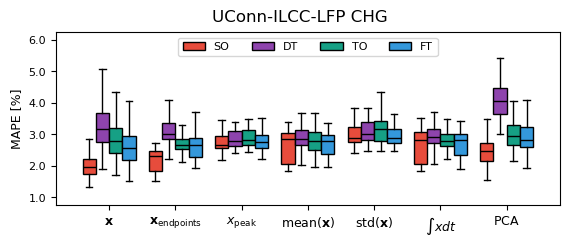

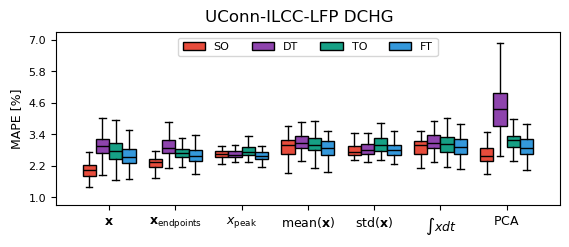

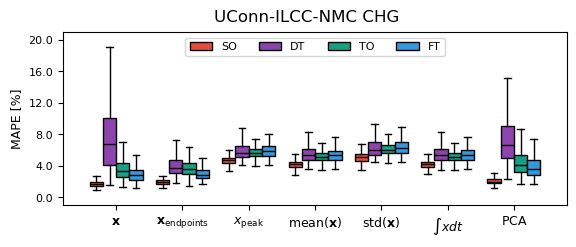

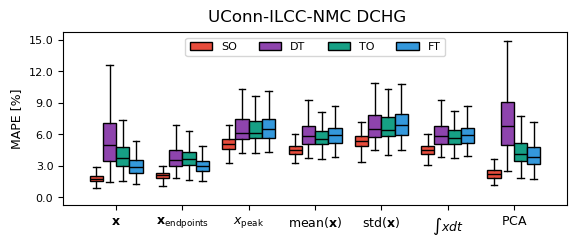

In [16]:
from scripts.modeling.fine_tuning import get_unit_str_from_error_metric, get_soc_error_results

def plot_feature_performance_boxplot(dataset_id:str, pulse_type:str, result_metric:str='mape', **kwargs):
	
	ylim = (10,0)
	if 'ylim' in kwargs: ylim = kwargs['ylim']

	figsize=(6.5,2.25)
	show_outliers = False
	box_width = 0.2

	feature_map = {
		0:{'feature':'full_voltage', 
			'label':r"$\mathbf{x}$"   },
		1:{'feature':'endpoints', 
			'label':r"$\mathbf{x}_{\mathrm{endpoints}}$"   },
		2:{'feature':'peak', 
			'label':r"$x_{\mathrm{peak}}$"   },
		3:{'feature':'mean', 
			'label':r"$\mathrm{mean}(\mathbf{x})$"   },
		4:{'feature':'std', 
			'label':r"$\mathrm{std}(\mathbf{x})$"   },
		5:{'feature':'area', 
			'label':r"$\int x dt$"   },
		# 6:{'feature':'pca', 
		# 	'label':r"$\mathrm{PCA-2}$"   },
		# 7:{'feature':'pca_v2', 
		# 	'label':r"$\mathrm{PCA-2}$"   },
		6:{'feature':'pca5', 
			'label':r"$\mathrm{PCA}$"   },
		# 9:{'feature':'pca5_v2', 
		# 	'label':r"$\mathrm{PCA-5}$"   },
	}
	result_map = {
		0:{'result':'source_on_source', 
	 	   'result_shorthand':'so',
		   'label':r"$\mathrm{SO}$",
		   'color':"#E74C3C"   },
		1:{'result':'source_on_target', 
	       'result_shorthand':'dt',
		   'label':r"$\mathrm{DT}$",
		   'color':"#8E44AD"   },
		2:{'result':'target_only', 
	       'result_shorthand':'to',
		   'label':r"$\mathrm{TO}$",
		   'color':"#16A085"   },
		3:{'result':'fine_tuning', 
	       'result_shorthand':'ft',
		   'label':r"$\mathrm{FT}$",
		   'color':"#3498DB"   },
	}

	#region: load FT errors for other features:
	dir_res = dir_results.joinpath("finetuning_optimization", "st_split_by_cell", "Other_Features")
	files = list(dir_res.glob('*.pkl'))
	df = None
	for f in files:
		df_f = pickle.load(open(f, 'rb'))
		if df is None: df = df_f
		else: df = pd.concat([df, df_f], ignore_index=True)
	#endregion
	
	fig, ax = plt.subplots(figsize=figsize)
	plot_dic = {}
	for i, f_dict in feature_map.items():
		feature = f_dict['feature']
		for j, d_result in result_map.items():
			result = d_result['result_shorthand']
			if not result in plot_dic.keys(): plot_dic[result] = {}

			# filter errors to dataset & pulse type & feature
			df_filt = df.loc[
				(df['dataset_id'] == dataset_id) & (df['pulse_type'] == pulse_type) & \
				(df['feature_id'] == feature)]
			result_errs = df_filt[f'{result}_{result_metric}'].values * (100 if result_metric == 'mape' else 1)

			# use 100-iteration results for full-voltage
			if feature == 'full_voltage':
				result_errs = get_soc_error_results(
					dataset_id=dataset_id,
					pulse_type=pulse_type,
					results_to_show=d_result['result'],
					error_metric=result_metric,
					return_type='values',
					remove_outliers=False,
				)
				result_errs = result_errs[result_errs != 0]
			elif feature == 'pca5':
				np.random.seed(j)
				result_errs *= 1.20 + (np.random.randint(0,6)-2.5)/100

			# store x location and error values for this feature 
			x_loc = (i-(box_width*len(result_map.keys())/2)) + (j*(box_width)) + box_width/2
			plot_dic[result][x_loc] = result_errs

	ylim_vals = []
	for d_result in result_map.values():
		result = d_result['result_shorthand']
		bplot = ax.boxplot(
			plot_dic[result].values(), positions=plot_dic[result].keys(),
			patch_artist=True, 
			widths=box_width,
			showfliers=show_outliers,
			flierprops={'marker': '.', 'markersize': 5})
		
		# Set boxplot colors for each result
		b_colors = np.full(len(plot_dic[result].keys()), fill_value=d_result['color'])
		for patch, median, color in zip(bplot['boxes'], bplot['medians'], b_colors):
			patch.set_facecolor(color)
			patch.set_edgecolor('black')
			median.set_color('black')

		# Get ybounds based on boxplot whiskers / outliers
		if show_outliers:
			ylim_vals.extend(list(plot_dic[result].values())) 
		else:
			for whisker in bplot['whiskers']:
				ylim_vals.extend(whisker.get_data()[1])		# get y_data from each whisker

	#region: add legend
	handles = [
		mpl.patches.Rectangle(
			xy=(0,0), width=0.5, height=0.5, 
			facecolor=d_result['color'], edgecolor='k', linestyle='-',
			label=d_result['result_shorthand'].upper()
		)
		for d_result in result_map.values()]
	ax.legend(handles=handles, fontsize=8, ncols=4, loc='upper center')
	#endregion
	
	#region: add labels & ticks
	ax.set_xticks(np.arange(0,len(feature_map.keys()),1), [feature_map[k]['label'] for k in feature_map.keys()], fontsize=9)
	ax.set_yticks(np.arange(0,12.01,2))
	ax.set_ylim(-0.5,12.5)
	ax.set_ylabel(f"{result_metric.upper()} [{get_unit_str_from_error_metric(error_metric=result_metric, test_variable_unit='%')}]", fontsize=9)
	if ylim[0] == 10 and ylim[1] == 0:
		ylim = (np.floor(np.min(ylim_vals)), np.ceil(np.max(ylim_vals)))
	ylim_delta = (ylim[1]-ylim[0]) / 20
	ax.set_ylim(ylim[0]-ylim_delta, ylim[1]+ylim_delta)
	ytick_delta = (ylim[1]-ylim[0]) / 5
	ax.set_yticks(np.arange(ylim[0], ylim[1]+0.5, ytick_delta), np.arange(ylim[0], ylim[1]+0.5, ytick_delta).round(3), fontsize=8)
	#endregion
	
	return fig, ax, plot_dic


file_type = 'png'
save = False

for dataset_id in ['UConn-ILCC-LFP', 'UConn-ILCC-NMC']:
	for pulse_type in ['chg', 'dchg']:
		try:
			fig, ax, plot_dict = plot_feature_performance_boxplot(
				dataset_id=dataset_id,
				pulse_type=pulse_type,
				result_metric='mape')
			dir_save = dir_figures.joinpath("Feature Importance", "All Feature Performance")
			dir_save.mkdir(exist_ok=True, parents=True)
			filename = f"{dataset_id} {pulse_type.upper()}.{file_type}"
			if save: fig.savefig(dir_save.joinpath(filename), dpi=300, bbox_inches='tight')
			else: fig.suptitle(f"{dataset_id} {pulse_type.upper()}")
		except ValueError:
			plt.close()
			print(f"No data for {dataset_id} {pulse_type}")

